#Procesamiento de Lenguaje Natural

Jonnatan Arias Garcia - Uniquindio - Utp
jonnatan.arias@utp.edu.co
jariasg@uniquindio.edu.co

##Imports

In [108]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

import numpy as np
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from collections import Counter
from pathlib import Path
import os
import numpy as np
import re
import string

# nltk text processors
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.corpus import wordnet


import unicodedata
import html
import pandas as pd
stop_words = stopwords.words('english')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Clasificador de reviews de peliculas IMBD

Son 50000 reviews de peliculas con etiqueta de positivo o negativo

In [109]:
dataset = pd.read_csv(r'https://github.com/dipanjanS/nlp_workshop_dhs18/raw/master/Unit%2011%20-%20Sentiment%20Analysis%20-%20Unsupervised%20Learning/movie_reviews.csv.bz2', compression='bz2')
dataset = dataset[:5000]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     5000 non-null   object
 1   sentiment  5000 non-null   object
dtypes: object(2)
memory usage: 78.2+ KB


In [110]:
# take a peek at the data
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [111]:
dataset.review[0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [112]:
dataset.sentiment[0]

'positive'

## Preproceso del Texto

* Replace weird characters
* Lowercase (minusculas)
* Tokenize
* Stemming & Lemmatize
* Remove stopwords

**Vamos a ver cómo preprocesar estos pasos uno por uno. A continuación, he construido un corpus de prueba o reseña **
### ejemplo preproc


In [113]:
test_corpus = '''The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?
The 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.
'''
test_corpus

'The Intel Core i5 processor that comes with the Dell Latitude 5490 is quad-core and offers 1.6GHz and a 6M cache. The base configuration includes 1 x 4GB of DDR4 Non-CC memory, but this can be upgraded to 8GB or even 16GB (2 x 8GB) if you require more memory. How great is that!?\nThe 14-inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution. Both versions are non-touch, WLAN capable, and come with anti-glare technology. You also get a built-in camera and microphone. For wireless technology, the system comes with a Qualcomm QCA61 x 4A 802.11 ac (2×2) wireless adapter+.\n'

In [114]:
# remove special characters & lowercase
clean_corpus = re.sub(r'[^\w\s]', '', test_corpus)
clean_corpus = clean_corpus.lower()
clean_corpus

'the intel core i5 processor that comes with the dell latitude 5490 is quadcore and offers 16ghz and a 6m cache the base configuration includes 1 x 4gb of ddr4 noncc memory but this can be upgraded to 8gb or even 16gb 2 x 8gb if you require more memory how great is that\nthe 14inch display is available with your choice of 1366 x 768 or 1920 x 1080 resolution both versions are nontouch wlan capable and come with antiglare technology you also get a builtin camera and microphone for wireless technology the system comes with a qualcomm qca61 x 4a 80211 ac 22 wireless adapter\n'

In [115]:
# tokenize
clean_tokens = wordpunct_tokenize(clean_corpus)
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'comes', 'with', 'the', 'dell', 'latitude', '5490', 'is', 'quadcore', 'and', 'offers', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'includes', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgraded', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'is', 'that', 'the', '14inch', 'display', 'is', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'versions', 'are', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'comes', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']


In [116]:
lemmatizer = WordNetLemmatizer()
clean_tokens = [lemmatizer.lemmatize(token) for token in clean_tokens]
clean_tokens = [lemmatizer.lemmatize(token, "v") for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '5490', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '1', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '2', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '1366', 'x', '768', 'or', '1920', 'x', '1080', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '80211', 'ac', '22', 'wireless', 'adapter']


In [117]:
clean_tokens = [re.sub(r'\b[0-9]+\b', '<NUM>', token) for token in clean_tokens]
print(clean_tokens)

['the', 'intel', 'core', 'i5', 'processor', 'that', 'come', 'with', 'the', 'dell', 'latitude', '<NUM>', 'be', 'quadcore', 'and', 'offer', '16ghz', 'and', 'a', '6m', 'cache', 'the', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'of', 'ddr4', 'noncc', 'memory', 'but', 'this', 'can', 'be', 'upgrade', 'to', '8gb', 'or', 'even', '16gb', '<NUM>', 'x', '8gb', 'if', 'you', 'require', 'more', 'memory', 'how', 'great', 'be', 'that', 'the', '14inch', 'display', 'be', 'available', 'with', 'your', 'choice', 'of', '<NUM>', 'x', '<NUM>', 'or', '<NUM>', 'x', '<NUM>', 'resolution', 'both', 'version', 'be', 'nontouch', 'wlan', 'capable', 'and', 'come', 'with', 'antiglare', 'technology', 'you', 'also', 'get', 'a', 'builtin', 'camera', 'and', 'microphone', 'for', 'wireless', 'technology', 'the', 'system', 'come', 'with', 'a', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']


In [118]:
stop_words = set(stopwords.words('english'))
clean_tokens = [token for token in clean_tokens if token not in stop_words]
print(clean_tokens)

['intel', 'core', 'i5', 'processor', 'come', 'dell', 'latitude', '<NUM>', 'quadcore', 'offer', '16ghz', '6m', 'cache', 'base', 'configuration', 'include', '<NUM>', 'x', '4gb', 'ddr4', 'noncc', 'memory', 'upgrade', '8gb', 'even', '16gb', '<NUM>', 'x', '8gb', 'require', 'memory', 'great', '14inch', 'display', 'available', 'choice', '<NUM>', 'x', '<NUM>', '<NUM>', 'x', '<NUM>', 'resolution', 'version', 'nontouch', 'wlan', 'capable', 'come', 'antiglare', 'technology', 'also', 'get', 'builtin', 'camera', 'microphone', 'wireless', 'technology', 'system', 'come', 'qualcomm', 'qca61', 'x', '4a', '<NUM>', 'ac', '<NUM>', 'wireless', 'adapter']


In [119]:
def build_vocab(corpus):
    vocab = {}
    for doc in corpus:
        for token in doc:
            if token not in vocab.keys():
                vocab[token] = len(vocab)
    return vocab

print(build_vocab([clean_tokens]))

{'intel': 0, 'core': 1, 'i5': 2, 'processor': 3, 'come': 4, 'dell': 5, 'latitude': 6, '<NUM>': 7, 'quadcore': 8, 'offer': 9, '16ghz': 10, '6m': 11, 'cache': 12, 'base': 13, 'configuration': 14, 'include': 15, 'x': 16, '4gb': 17, 'ddr4': 18, 'noncc': 19, 'memory': 20, 'upgrade': 21, '8gb': 22, 'even': 23, '16gb': 24, 'require': 25, 'great': 26, '14inch': 27, 'display': 28, 'available': 29, 'choice': 30, 'resolution': 31, 'version': 32, 'nontouch': 33, 'wlan': 34, 'capable': 35, 'antiglare': 36, 'technology': 37, 'also': 38, 'get': 39, 'builtin': 40, 'camera': 41, 'microphone': 42, 'wireless': 43, 'system': 44, 'qualcomm': 45, 'qca61': 46, '4a': 47, 'ac': 48, 'adapter': 49}


In [120]:
def build_index2token(vocab):
    index2token = {}
    for token in vocab.keys():
        index2token[vocab[token]] = token
    return index2token

print(build_index2token(build_vocab([clean_tokens])))

{0: 'intel', 1: 'core', 2: 'i5', 3: 'processor', 4: 'come', 5: 'dell', 6: 'latitude', 7: '<NUM>', 8: 'quadcore', 9: 'offer', 10: '16ghz', 11: '6m', 12: 'cache', 13: 'base', 14: 'configuration', 15: 'include', 16: 'x', 17: '4gb', 18: 'ddr4', 19: 'noncc', 20: 'memory', 21: 'upgrade', 22: '8gb', 23: 'even', 24: '16gb', 25: 'require', 26: 'great', 27: '14inch', 28: 'display', 29: 'available', 30: 'choice', 31: 'resolution', 32: 'version', 33: 'nontouch', 34: 'wlan', 35: 'capable', 36: 'antiglare', 37: 'technology', 38: 'also', 39: 'get', 40: 'builtin', 41: 'camera', 42: 'microphone', 43: 'wireless', 44: 'system', 45: 'qualcomm', 46: 'qca61', 47: '4a', 48: 'ac', 49: 'adapter'}


### Preproc. en dataset

Utils para
**Bag of Words**
&
**TF-IDF**

In [121]:
def remove_rare_words(tokens, common_tokens, max_len):
    return [token if token in common_tokens else '<UNK>' for token in tokens][-max_len:]

def replace_numbers(tokens):
    return [re.sub(r'[0-9]+', '<NUM>', token) for token in tokens]

def tokenize(text, stop_words, lemmatizer):
    text = re.sub(r'[^\w\s]', '', text) # remove special characters
    text = text.lower() # lowercase
    tokens = wordpunct_tokenize(text) # tokenize
    tokens = [lemmatizer.lemmatize(token) for token in tokens] # noun lemmatizer
    tokens = [lemmatizer.lemmatize(token, "v") for token in tokens] # verb lemmatizer
    tokens = [token for token in tokens if token not in stop_words] # remove stopwords
    return tokens

def build_bow_vector(sequence, idx2token):
    vector = [0] * len(idx2token)
    for token_idx in sequence:
        if token_idx not in idx2token:
            raise ValueError('Wrong sequence index found!')
        else:
            vector[token_idx] += 1
    return vector

## Preparando data

In [122]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [123]:
from functools import partial
# Set parameters
max_vocab=5000
max_len=128


stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
dataset['tokens'] = dataset.review.apply(
    partial(
        tokenize,
        stop_words=stop_words,
        lemmatizer=lemmatizer,
    ),
)

all_tokens = [token for doc in list(dataset.tokens) for token in doc]

# Build most common tokens bound by max vocab size
common_tokens = set(
    list(
        zip(*Counter(all_tokens).most_common(max_vocab))
    )[0]
)

# Replace rare words with <UNK>
dataset.loc[:, 'tokens'] = dataset.tokens.apply(
    partial(
        remove_rare_words,
        common_tokens=common_tokens,
        max_len=max_len,
    ),
)

# Replace numbers with <NUM>
dataset.loc[:, 'tokens'] = dataset.tokens.apply(replace_numbers)

# Remove sequences with only <UNK>
dataset = dataset[dataset.tokens.apply(
    lambda tokens: any(token != '<UNK>' for token in tokens),
)]

# Build vocab
vocab = sorted(set(
    token for doc in list(dataset.tokens) for token in doc
))
token2idx = {token: idx for idx, token in enumerate(vocab)}
idx2token = {idx: token for token, idx in token2idx.items()}

In [124]:
dataset

,review,sentiment,tokens
0,One of the other reviewers has mentioned that ...,positive,"[<UNK>, give, <UNK>, maximum, security, state,..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, br, br, film, ..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wa, wonderful, way, spend, time, hot, ..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[time, money, visually, stun, film, watch, mr,..."
...,...,...,...
4995,An interesting slasher film with multiple susp...,negative,"[interest, slasher, film, multiple, <UNK>, br,..."
4996,i watched this series when it first came out i...,positive,"[<NUM>, make, difficult, subject, <UNK>, maker..."
4997,Once again Jet Li brings his charismatic prese...,positive,"[super, soldier, program, seek, <UNK>, humanit..."
4998,"I rented this movie, after hearing Chris Gore ...",negative,"[wrestle, indie, wrestle, even, <UNK>, wrestle..."


In [125]:
# Convert tokens to indexes
dataset['indexed_tokens'] = dataset.tokens.apply(
    lambda doc: [token2idx[token] for token in doc],
)

# Build BoW vector
dataset['bow_vector'] = dataset.indexed_tokens.apply(
    build_bow_vector, args=(idx2token,)
)

In [126]:
dataset

,review,sentiment,tokens,indexed_tokens,bow_vector
0,One of the other reviewers has mentioned that ...,positive,"[<UNK>, give, <UNK>, maximum, security, state,...","[8, 1867, 8, 2715, 3846, 4152, 8, 1713, 2651, ...","[0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0,..."
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, br, br, film, ...","[4852, 2572, 3406, 514, 514, 1658, 4353, 8, 8,...","[0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0,..."
2,I thought this was a wonderful way to spend ti...,positive,"[think, wa, wonderful, way, spend, time, hot, ...","[4406, 4722, 4852, 4763, 4104, 4437, 2122, 426...","[1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, ..."
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ...","[364, 1599, 2572, 512, 2346, 4406, 4919, 796, ...","[2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ..."
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[time, money, visually, stun, film, watch, mr,...","[4437, 2832, 4705, 4222, 1658, 4756, 2876, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...
4995,An interesting slasher film with multiple susp...,negative,"[interest, slasher, film, multiple, <UNK>, br,...","[2288, 4010, 1658, 2882, 8, 514, 2209, 4559, 1...","[1, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0,..."
4996,i watched this series when it first came out i...,positive,"[<NUM>, make, difficult, subject, <UNK>, maker...","[0, 2656, 1201, 4230, 8, 2657, 525, 907, 3962,...","[1, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0,..."
4997,Once again Jet Li brings his charismatic prese...,positive,"[super, soldier, program, seek, <UNK>, humanit...","[4264, 4051, 3415, 3851, 8, 2139, 3415, 4325, ...","[1, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0,..."
4998,"I rented this movie, after hearing Chris Gore ...",negative,"[wrestle, indie, wrestle, even, <UNK>, wrestle...","[4883, 2226, 4883, 1497, 8, 4883, 1336, 4855, ...","[1, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0,..."


In [127]:
# Build TF-IDF vector
vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=lambda doc: doc,
    preprocessor=lambda doc: doc,
    token_pattern=None,
    max_features=5000
)
vectors = vectorizer.fit_transform(dataset.tokens).toarray()
# dataset['tfidf_vector'] = [vector.tolist() for vector in vectors]

tfidf_vector

In [128]:
vectors

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04525219, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.03426514, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02609989, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.13494927, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [129]:
vectorizer.vocabulary_

{'<UNK>': 8,
 'give': 1867,
 'maximum': 2715,
 'security': 3846,
 'state': 4152,
 'focus': 1713,
 'mainly': 2651,
 'city': 762,
 'experimental': 1551,
 'section': 3844,
 'prison': 3392,
 'cell': 669,
 'glass': 1870,
 'front': 1780,
 'face': 1579,
 'high': 2058,
 'agenda': 101,
 'em': 1409,
 'home': 2093,
 'muslim': 2895,
 'latino': 2483,
 'christian': 743,
 'italian': 2330,
 'irish': 2318,
 'death': 1100,
 'stare': 4146,
 'dodgy': 1266,
 'deal': 1096,
 'never': 2956,
 'far': 1605,
 'br': 514,
 'would': 4875,
 'say': 3794,
 'main': 2650,
 'appeal': 218,
 'show': 3945,
 'due': 1322,
 'fact': 1582,
 'go': 1879,
 'wouldnt': 4876,
 'dare': 1073,
 'forget': 1731,
 'pretty': 3372,
 'picture': 3248,
 'paint': 3141,
 'mainstream': 2652,
 'audience': 295,
 'charm': 706,
 'doesnt': 1268,
 'mess': 2756,
 'around': 243,
 'first': 1677,
 'episode': 1467,
 'ever': 1500,
 'saw': 3793,
 'strike': 4206,
 'nasty': 2919,
 'wa': 4722,
 'surreal': 4285,
 'couldnt': 966,
 'ready': 3526,
 'watch': 4756,
 'dev

In [130]:
#organizando las etiquetas (Y data)

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(dataset.sentiment)
dataset['target'] = encoder.transform(dataset.sentiment)


In [131]:
dataset

,review,sentiment,tokens,indexed_tokens,bow_vector,target
0,One of the other reviewers has mentioned that ...,positive,"[<UNK>, give, <UNK>, maximum, security, state,...","[8, 1867, 8, 2715, 3846, 4152, 8, 1713, 2651, ...","[0, 0, 0, 0, 0, 0, 0, 0, 22, 0, 0, 0, 0, 0, 0,...",1
1,A wonderful little production. <br /><br />The...,positive,"[wonderful, little, production, br, br, film, ...","[4852, 2572, 3406, 514, 514, 1658, 4353, 8, 8,...","[0, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0,...",1
2,I thought this was a wonderful way to spend ti...,positive,"[think, wa, wonderful, way, spend, time, hot, ...","[4406, 4722, 4852, 4763, 4104, 4437, 2122, 426...","[1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, ...",1
3,Basically there's a family where a little boy ...,negative,"[basically, family, little, boy, jake, think, ...","[364, 1599, 2572, 512, 2346, 4406, 4919, 796, ...","[2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, ...",0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,"[time, money, visually, stun, film, watch, mr,...","[4437, 2832, 4705, 4222, 1658, 4756, 2876, 8, ...","[0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0,...",1
...,...,...,...,...,...,...
4995,An interesting slasher film with multiple susp...,negative,"[interest, slasher, film, multiple, <UNK>, br,...","[2288, 4010, 1658, 2882, 8, 514, 2209, 4559, 1...","[1, 0, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0,...",0
4996,i watched this series when it first came out i...,positive,"[<NUM>, make, difficult, subject, <UNK>, maker...","[0, 2656, 1201, 4230, 8, 2657, 525, 907, 3962,...","[1, 0, 0, 0, 0, 0, 0, 0, 29, 0, 0, 0, 0, 0, 0,...",1
4997,Once again Jet Li brings his charismatic prese...,positive,"[super, soldier, program, seek, <UNK>, humanit...","[4264, 4051, 3415, 3851, 8, 2139, 3415, 4325, ...","[1, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0,...",1
4998,"I rented this movie, after hearing Chris Gore ...",negative,"[wrestle, indie, wrestle, even, <UNK>, wrestle...","[4883, 2226, 4883, 1497, 8, 4883, 1336, 4855, ...","[1, 0, 0, 0, 0, 0, 0, 0, 14, 0, 0, 0, 0, 0, 0,...",0


In [132]:
print('Number of records:', len(dataset), '\n')

import random
random_idx = random.randint(0,len(dataset)-1)
print('index:', random_idx, '\n')
print(dataset.review[random_idx], '\n')
print(dataset.indexed_tokens[random_idx], '\n')
print('BoW vector size:', len(dataset.bow_vector[random_idx]), '\n')
print('TF-IDF vector size:', len(vectors), '\n')



print('Sentiment:', dataset.target[random_idx], dataset.sentiment[random_idx], '\n')

Number of records: 5000 

index: 4376 

The movie is really about choices. In the oppressed state of affairs as seen in Fire, where good women had to be obedient and do what was correct in the eyes of tradition, there seemed few options for Radha and Sita. However, granted that it was not their only option. What is life without desire, Radha questions Ashok. Yes, it's true that life provides us with a number of options but how many we can take depends on a number of external factors. When your world is confined to a small Indian household, being a dutiful daughter-in-law to a silent but observant still powerful matriarch, a dutiful wife of 13 years to a man who has taken a vow of celibacy due to your not being able to have a child, a man who only wants you lying next to him to prove his strength in eliminating his desires. I felt the ladies had little choice but to find solace in each other's company. I guess the fact that so many women applauded Ms Mehta's work, was because it provide

## Train test split (para BoW)

In [133]:
#ajustamos a formato Numpy array

# Convertir cada lista interna en un arreglo NumPy
arreglos_np = [np.array(sublista) for sublista in dataset['bow_vector']]
# Convertir la lista de arreglos NumPy en un arreglo NumPy
x_full = np.array(arreglos_np).astype('float32')


In [134]:
from sklearn.model_selection import train_test_split

#BoW model
# x_full = dataset['bow_vector']
y_full = dataset['target'].astype('float32')

X_train, X_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42,shuffle='True')

### model

In [135]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(len(dataset.bow_vector[random_idx]),)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 16)                78768     
                                                                 
 dense_25 (Dense)            (None, 16)                272       
                                                                 
 dense_26 (Dense)            (None, 1)                 17        
                                                                 
Total params: 79057 (308.82 KB)
Trainable params: 79057 (308.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [136]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

###Train

In [137]:
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
100/100 [==============================] - 1s 5ms/step - loss: 0.5227 - binary_accuracy: 0.7631 - val_loss: 0.3699 - val_binary_accuracy: 0.8500
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.2225 - binary_accuracy: 0.9237 - val_loss: 0.3793 - val_binary_accuracy: 0.8462
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0970 - binary_accuracy: 0.9759 - val_loss: 0.4342 - val_binary_accuracy: 0.8275
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0442 - binary_accuracy: 0.9934 - val_loss: 0.4912 - val_binary_accuracy: 0.8313
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0204 - binary_accuracy: 0.9981 - val_loss: 0.5513 - val_binary_accuracy: 0.8250
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0107 - binary_accuracy: 0.9994 - val_loss: 0.6016 - val_binary_accuracy: 0.8263
Epoch 7/10
100/100 [==============================] - 0s 4ms/ste

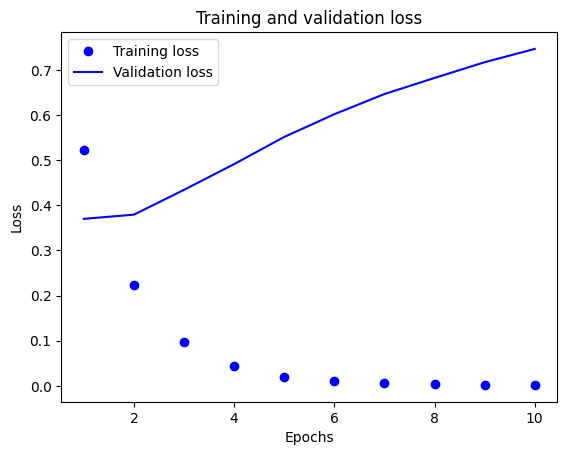

In [138]:
history_dict = history.history
history_dict.keys()


acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

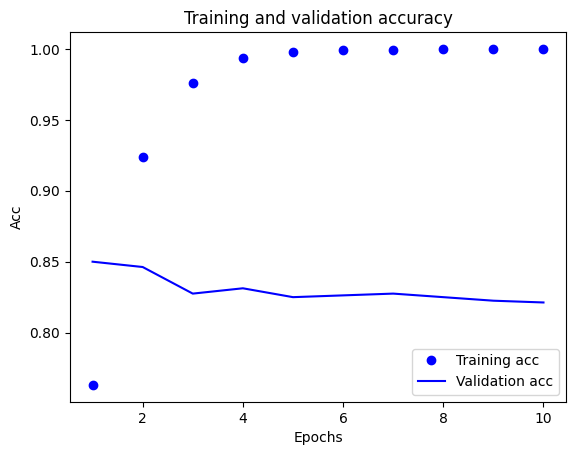

In [139]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Model evaluation & predicts

In [140]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

32/32 [==============================] - 0s 2ms/step - loss: 0.6204 - binary_accuracy: 0.8430
Accuracy: 84.30%


In [141]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
label = ['positive' if item == 1 else 'negative' for item in pred]
print(pred)


32/32 [==============================] - 0s 2ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Como puedes ver, el efecto es mínimo, pero la curva val es un poco más suave en caso de limpieza de texto.

** ¿Dio bien? ahi, pero sabemos el por qué? **

Ya limitamos el vocabulario a las max_vocab=5000  palabras más frecuentes, y usamos características de BoW, por lo que limpiar el texto tiene un efecto mínimo, ya que se descuida el contexto de las palabras (es probable que las palabras de alta frecuencia siempre obtengan puntuación sin importar que a veces se puedan perder diferentes morfologías).

Por ejemplo, para modelos de words embedding (como veremos), el contexto de la palabra tendrá un fuerte efecto, por lo que el paso de limpieza tendrá más importancia.

## Train test split (para TF-IDF)

In [142]:
# Convertir la lista de arreglos NumPy en un arreglo NumPy
x_full = np.array(vectors).astype('float32')


In [143]:
from sklearn.model_selection import train_test_split

#BoW model
# x_full = dataset['bow_vector']
y_full = dataset['target'].astype('float32')

X_train, X_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, random_state=42,shuffle='True')

### model

In [144]:
from tensorflow.keras import models
from tensorflow.keras import layers

model2 = models.Sequential()
model2.add(layers.Dense(16, activation='relu', input_shape=(len(vectors[random_idx]),)))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 16)                78768     
                                                                 
 dense_28 (Dense)            (None, 16)                272       
                                                                 
 dense_29 (Dense)            (None, 1)                 17        
                                                                 
Total params: 79057 (308.82 KB)
Trainable params: 79057 (308.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [145]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import optimizers

model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

###Train

In [146]:
history2 = model2.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)

Epoch 1/10
100/100 [==============================] - 2s 10ms/step - loss: 0.6693 - binary_accuracy: 0.7019 - val_loss: 0.6074 - val_binary_accuracy: 0.8350
Epoch 2/10
100/100 [==============================] - 0s 4ms/step - loss: 0.4488 - binary_accuracy: 0.8959 - val_loss: 0.3920 - val_binary_accuracy: 0.8475
Epoch 3/10
100/100 [==============================] - 0s 4ms/step - loss: 0.2230 - binary_accuracy: 0.9372 - val_loss: 0.3450 - val_binary_accuracy: 0.8388
Epoch 4/10
100/100 [==============================] - 0s 4ms/step - loss: 0.1223 - binary_accuracy: 0.9716 - val_loss: 0.3599 - val_binary_accuracy: 0.8313
Epoch 5/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0665 - binary_accuracy: 0.9897 - val_loss: 0.4009 - val_binary_accuracy: 0.8325
Epoch 6/10
100/100 [==============================] - 0s 4ms/step - loss: 0.0368 - binary_accuracy: 0.9978 - val_loss: 0.4327 - val_binary_accuracy: 0.8175
Epoch 7/10
100/100 [==============================] - 0s 4ms/st

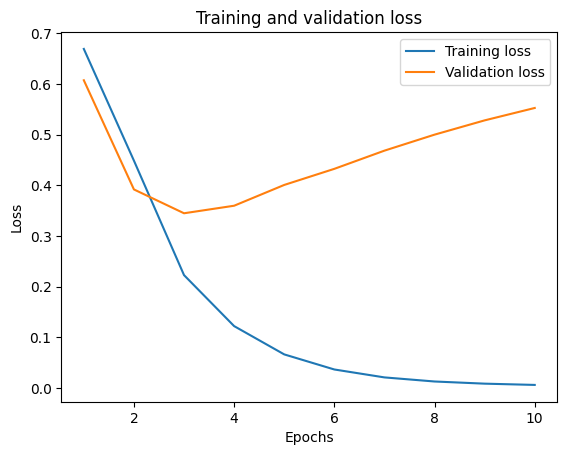

In [147]:
history_dict2 = history2.history
history_dict2.keys()


acc2 = history2.history['binary_accuracy']
val_acc2 = history2.history['val_binary_accuracy']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

epochs = range(1, len(acc2) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss2, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss2, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

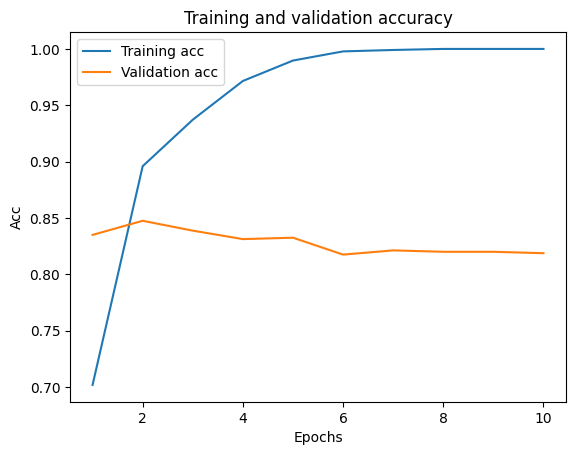

In [148]:
plt.clf()   # clear figure
acc_values2 = history_dict2['binary_accuracy']
val_acc_values2 = history_dict2['val_binary_accuracy']

plt.plot(epochs, acc2, label='Training acc')
plt.plot(epochs, val_acc2, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

### Model evaluation & predicts

In [149]:
# Final evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores2[1]*100))

32/32 [==============================] - 0s 2ms/step - loss: 0.4673 - binary_accuracy: 0.8440
Accuracy: 84.40%


In [150]:
pred2 = model2.predict(X_test)
pred2 = np.argmax(pred2,axis=1)
label2 = ['positive' if item == 1 else 'negative' for item in pred2]
print(pred2)


32/32 [==============================] - 0s 2ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

Como puedes ver, el efecto es mínimo, pero la curva val es un poco más suave en caso de limpieza de texto.

** ¿Dio bien? ahi, pero sabemos el por qué? **

Ya limitamos el vocabulario a las max_vocab=5000  palabras más frecuentes, y usamos características de BoW, por lo que limpiar el texto tiene un efecto mínimo, ya que se descuida el contexto de las palabras (es probable que las palabras de alta frecuencia siempre obtengan puntuación sin importar que a veces se puedan perder diferentes morfologías).

Por ejemplo, para modelos de words embedding (como veremos), el contexto de la palabra tendrá un fuerte efecto, por lo que el paso de limpieza tendrá más importancia.

** Bag Of Words y vectores **
Sufre dos problemas.
1. Pierde información de secuencia.
2. Esparcidad: Los escalares de entrada representan indices de palabras. Estos son dispersos y no incluyen ninguna información sobre la palabra (¿Es verbo, sustantivo, sarcastmos,...?) Ademas, esta entrada es muy dispersa, donde en una oración solo tenemos unas pocas palabras del vocabulario.


Por lo tanto, podremos usar capaz embeddings que codifica los factores latentes de características de las palabras.

## Train Test Split (Word Embedding)

Un embedding de palabras es una clase de enfoques para representar palabras y documentos usando una representación de vector densa.

Es una mejora sobre los esquemas de codificación más tradicionales de bolsa de palabras donde se usaban vectores grandes y dispersos para representar cada palabra o para puntuar cada palabra dentro de un vector para representar un vocabulario completo.
Estas representaciones eran dispersas porque los vocabularios eran vastos y una palabra o documento dado serían por vectores largos comprimido en valores zero.

Ejemplos populares de métodos de aprendizaje de embeddings de palabras a partir de texto incluyen:

- Word2Vec.
- GloVe.


Además de estos métodos cuidadosamente diseñados, un embedding de palabras puede aprenderse como parte de un modelo de aprendizaje profundo. Este enfoque puede ser más lento, pero adapta el modelo a un conjunto de datos de entrenamiento específico.

**Capa Embedding en Keras**


Keras ofrece una capa para redes neuronales en datos de texto.

Puedes pensar en ella como:

LUT
Matriz de pesos: n_vocab x emb_sz


Requiere que los datos de entrada estén codificados con números enteros, de modo que cada palabra esté representada por un número entero único.


Este paso de preparación de datos se puede realizar utilizando la API Tokenizer que también se proporciona con Keras.


La capa Embedding se inicializa con pesos aleatorios y aprenderá una incrustación para todas las palabras en el conjunto de datos de entrenamiento.

Es una capa que se puede utilizar de diversas formas, como por ejemplo:

* Embebidos desde cero: Se puede usar solo para aprender un embedding de palabras que se puede guardar y usar en otro modelo más adelante.

* Embebidos que se pueden aprender: Se puede utilizar como parte de un modelo de aprendizaje profundo en el que la incorporación se aprende junto con el modelo en sí.

* Embebidos previamente entrenadas: Se puede utilizar para cargar un modelo de incrustación de palabras previamente entrenado, un tipo de aprendizaje por transferencia. Esto se puede combinar con incrustaciones que se pueden aprender, donde esos pesos se actualizan o congelan posteriormente como parte del modelo más grande.

La capa de Embedding tiene pesos que se aprenden. Si guarda su modelo en un archivo, esto incluirá pesos para la capa de incrustación.

La salida de la capa de incrustación es un vector 2D con un embedding para cada palabra en la secuencia de palabras de entrada (documento de entrada).

Si desea conectar una capa Densa directamente a una capa de embedding, primero debe aplanar la matriz de salida 2D a un vector 1D usando la capa Aplanar.

Ahora, veamos cómo podemos usar una capa de incrustación en la práctica.

### Ejemplo basico de uso

Keras tiene la funcion one_hot() que crea un arreglo de cada palabra como un escalar.

In [151]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
import numpy as np

# define documents
docs = ['Well done!',
'Good work','Great effort',
'nice work',
'Excellent!',
'Weak',
'Poor effort!',
'not good',
'poor work',
'Could have done better.']

# define class labels
labels = [1,1,1,1,1,0,0,0,0,0]


# integer encode the documents
#vocab_size = 50

#encoded_docs = [one_hot(d, vocab_size) for d in docs]
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
print(encoded_docs)

# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)

# define the model
modelE = Sequential()
modelE.add(Embedding(vocab_size, 8, input_length=max_length))
modelE.add(Flatten())
modelE.add(Dense(1, activation='sigmoid'))
# compile the model
modelE.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# summarize the model
modelE.summary()
# fit the model
modelE.fit(np.array(padded_docs), np.array(labels), epochs=50, verbose=0)
# evaluate the model
loss, accuracy = modelE.evaluate(np.array(padded_docs), np.array(labels), verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[6, 2], [3, 1], [7, 4], [8, 1], [9], [10], [5, 4], [11, 3], [5, 1], [12, 13, 2, 14]]
[[ 6  2  0  0]
 [ 3  1  0  0]
 [ 7  4  0  0]
 [ 8  1  0  0]
 [ 9  0  0  0]
 [10  0  0  0]
 [ 5  4  0  0]
 [11  3  0  0]
 [ 5  1  0  0]
 [12 13  2 14]]
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 4, 8)              120       
                                                                 
 flatten_10 (Flatten)        (None, 32)                0         
                                                                 
 dense_30 (Dense)            (None, 1)                 33        
                                                                 
Total params: 153 (612.00 Byte)
Trainable params: 153 (612.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Accuracy: 80.000001


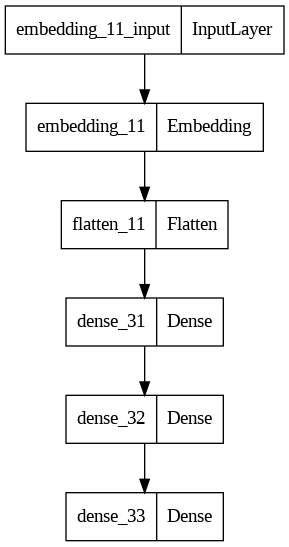

In [152]:
emb_sz = 50
n_latent_factors = 25
max_length = 4 #of words
modelE2 = models.Sequential()
modelE2.add(layers.Embedding(vocab_size+1, n_latent_factors, input_length=max_length))
modelE2.add(layers.Flatten())
modelE2.add(layers.Dense(emb_sz, activation='relu'))
modelE2.add(layers.Dense(16, activation='relu'))
modelE2.add(layers.Dense(1, activation='sigmoid'))
plot_model(modelE2)

### capa embedding

In [153]:
dataset.tokens

0       [<UNK>, give, <UNK>, maximum, security, state,...
1       [wonderful, little, production, br, br, film, ...
2       [think, wa, wonderful, way, spend, time, hot, ...
3       [basically, family, little, boy, jake, think, ...
4       [time, money, visually, stun, film, watch, mr,...
                              ...                        
4995    [interest, slasher, film, multiple, <UNK>, br,...
4996    [<NUM>, make, difficult, subject, <UNK>, maker...
4997    [super, soldier, program, seek, <UNK>, humanit...
4998    [wrestle, indie, wrestle, even, <UNK>, wrestle...
4999    [wa, big, disappointment, think, worst, <UNK>,...
Name: tokens, Length: 5000, dtype: object

In [154]:
from sklearn.model_selection import train_test_split

# Convertir la lista de arreglos NumPy en un arreglo NumPy
x_fullE = dataset['review']
y_fullE = dataset['target'].astype('float32')

X_trainE, X_testE, y_trainE, y_testE = train_test_split(x_fullE, y_fullE, test_size=0.2, random_state=42,shuffle='True')

In [155]:
vocab_sz = 5000
# (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_sz)

tok = Tokenizer(num_words=vocab_sz, oov_token='UNK')
tok.fit_on_texts(x_fullE)
#vocab_sz = len(tok.word_index)

x_traine = tok.texts_to_sequences(X_trainE)
x_teste = tok.texts_to_sequences(X_testE)
# Extract binary BoW features
x_traine = tok.sequences_to_matrix(x_traine, mode='binary')
x_teste = tok.sequences_to_matrix(x_teste, mode='binary')
y_traine = np.asarray(y_trainE).astype('float32')
y_teste = np.asarray(y_testE).astype('float32')

In [156]:
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

history2 = model2.fit(x_traine,
                    y_traine,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
history_dict = history.history
history_dict.keys()

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node sequential_14/dense_27/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-156-6826aa709573>", line 5, in <cell line: 5>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [32,5000], In[1]: [4922,16]
	 [[{{node sequential_14/dense_27/Relu}}]] [Op:__inference_train_function_98386]

**Por que no funciono?**

anteriormente se codifico:
* 1-> exite palabra en el texto
* 0-> no existe palabra en la texto


Ya no tenemos el indice de palabra como caracteristica, En otras palabras, la entrada a la capa embedding es invalida, ya que embedding solo recibe el indice de las palabras.

Que hacemos?
1, buscar la forma de tener indices {x_traine = tok.texts_to_sequences(X_trainE)} ademas, dado que tenemos capaz densas, es necesario un tamaño fijo e igual. (usaremos pad_sequences)

**PAD token: Embedding**
El tamaño de la tabla embebida es tamaño de vocabulario + 1   Por tamaño del embebido

+1 es debido a que queremos reservar memoria para palabras nuevas.
en bow, agregabamos un cero


In [157]:
max_length = 100
x_traine = pad_sequences(x_traine, maxlen=max_length, padding='post')
x_teste = pad_sequences(x_teste, maxlen=max_length, padding='post')

In [158]:
n_latent_factors = 25
modele = models.Sequential()
modele.add(layers.Embedding(vocab_sz+1, n_latent_factors, input_length=max_length))
modele.add(layers.Flatten())
modele.add(layers.Dense(16, activation='relu'))
modele.add(layers.Dense(16, activation='relu'))
modele.add(layers.Dense(1, activation='sigmoid'))
modele.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 25)           125025    
                                                                 
 flatten_12 (Flatten)        (None, 2500)              0         
                                                                 
 dense_34 (Dense)            (None, 16)                40016     
                                                                 
 dense_35 (Dense)            (None, 16)                272       
                                                                 
 dense_36 (Dense)            (None, 1)                 17        
                                                                 
Total params: 165330 (645.82 KB)
Trainable params: 165330 (645.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


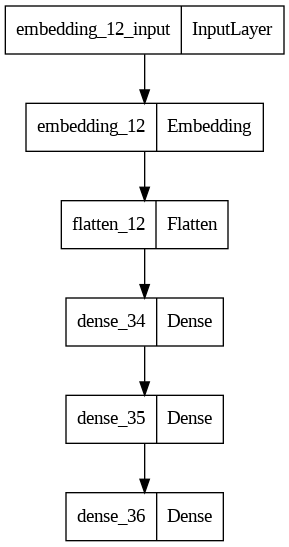

In [159]:
plot_model(modele)

In [160]:
modele.compile(optimizer=optimizers.RMSprop(learning_rate=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

historye = modele.fit(x_traine,
                    y_traine,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2)
history_dicte = historye.history
history_dicte.keys()

Epoch 1/100
100/100 [==============================] - 1s 5ms/step - loss: 0.6936 - binary_accuracy: 0.4800 - val_loss: 0.6932 - val_binary_accuracy: 0.4888
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6934 - binary_accuracy: 0.4856 - val_loss: 0.6934 - val_binary_accuracy: 0.4888
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6932 - binary_accuracy: 0.5034 - val_loss: 0.6932 - val_binary_accuracy: 0.4888
Epoch 4/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6932 - binary_accuracy: 0.5034 - val_loss: 0.6933 - val_binary_accuracy: 0.4888
Epoch 5/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6932 - binary_accuracy: 0.5034 - val_loss: 0.6933 - val_binary_accuracy: 0.4888
Epoch 6/100
100/100 [==============================] - 0s 4ms/step - loss: 0.6932 - binary_accuracy: 0.5034 - val_loss: 0.6933 - val_binary_accuracy: 0.4888
Epoch 7/100
100/100 [==============================] - 0s 

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

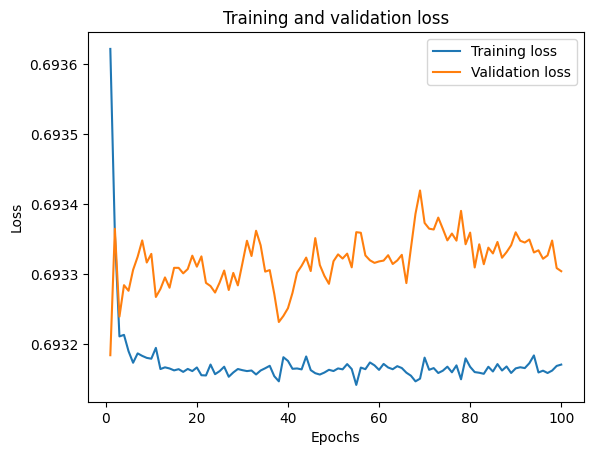

In [161]:
acc = historye.history['binary_accuracy']
val_acc = historye.history['val_binary_accuracy']
loss = historye.history['loss']
val_loss = historye.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

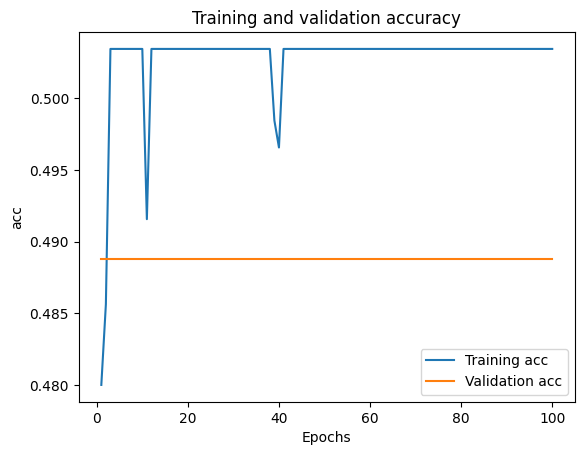

In [162]:
plt.clf()   # clear figure
acc_values = history_dicte['binary_accuracy']
val_acc_values = history_dicte['val_binary_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.legend()

plt.show()

Los modelos base para el pln dan una buen inicio para el procesamiento de texto, sin embargo suelen tener problemas a la hora de contrastar la secuencia de palabras de buena forma, por ende es vital cambiar o agregar una capa pos embebida para que me genere información reelevante sobre la secuencia de indices textuales.

Siendo las capaz recurrentes el principal candidato.